In [153]:
%matplotlib inline

# Recipe graph

## Get a list of recipes

```
wget https://www.auntiesrecipes.co.uk/code/titles.json
```

Courtesy of this repository:

https://github.com/user24/auntiesrecipes

Example recipes:

http://www.bbc.co.uk/food/recipes/chicken_and_bacon_21897

http://www.bbc.co.uk/food/recipes/courgettebread_85718

http://www.bbc.co.uk/food/recipes/fairtradebananabread_72082


In [231]:
import json

In [232]:
titles = json.load(open('titles.json'))

In [336]:
def clean_ingredient(ingredient):
    '''
    Chop off any modifiers, such as "to taste", "halved", etc...
    
    :param ingredient: The name of the ingredient (e.g., "nutmeg", "pepper, chopped")
    '''
    return ingredient.strip().split(',')[0]

## Downloading the recipe web pages

First we'll download a set of web pages containing different recipes. For now, we'll just store these web pages and parse them later to extract ingredients

In [337]:
responses = {}

In [338]:
import requests
import sys


# go through all the recipes
print("total recipes:", len(titles.keys()))

for i,recipe_name in enumerate(titles.keys()[100:200]):
    # get the web page
    responses[recipe_name] = requests.get("http://www.bbc.co.uk/food/recipes/" + recipe_name)
    sys.stdout.write("{} ".format(i))


                

('total recipes:', 11161)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

## Parsing for ingredients

Each web page contains a list of ingredients, but they're formatted as HTML and unpleasant to read:

```
    <ul class="recipe-ingredients__list">
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 6 skinless <a href="/food/chicken_leg" class="recipe-ingredients__link">chicken legs</a> (thigh and drumstick)	</li>
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 4 <a href="/food/celery" class="recipe-ingredients__link">celery</a> sticks, diced</li>
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 4 <a href="/food/bay_leaf" class="recipe-ingredients__link">bay leaves</a>, roughly sliced</li>
   </ul>
```

We want to extract they ingredient names and store them in a more friendly data structure.

In [234]:
import lxml.etree as etree
import lxml.cssselect as ls
import cssselect as css

import collections as col

def create_ingredients_map(responses, clean_ingredient=lambda x: x):
    ingredients_map = col.defaultdict(lambda: {'coingredients': set(), 'recipes': set()})

    for recipe_name,response in responses:    
        # select ingredient lists
        expression = css.GenericTranslator().css_to_xpath('ul')
        sel = ls.CSSSelector('.recipe-ingredients__list')

        tree = etree.HTML(response.content)
        ingredient_lists = sel(tree)

        # go through each ingredient in the ingredient list
        sel_ingredient = ls.CSSSelector('.recipe-ingredients__link')
        for ingredients_list in ingredient_lists:
            for ingredient in sel_ingredient(ingredients_list):
                ingredient_name = clean_ingredient(etree.tostring(ingredient, encoding='iso-8859-1', method='text')).decode('utf-8')
                ingredients_map[ingredient_name]['recipes'].add(recipe_name)

                for coingredient in sel_ingredient(ingredients_list):
                    coingredient = clean_ingredient(etree.tostring(coingredient, encoding='iso-8859-1', method='text')).decode('utf-8')

                    if coingredient == ingredient_name:
                        continue


                    ingredients_map[ingredient_name]['coingredients'].add(coingredient)
                    
    return ingredients_map

In [235]:
used_responses = responses.items()[:3]
print([v[0] for v in used_responses])

[u'chicken_and_bacon_21897', u'courgettebread_85718', u'fairtradebananabread_72082']


In [270]:
ingredients_map = create_ingredients_map(used_responses)
print("\n".join(ingredients_map.keys()[:]))

celery sticks, diced
baking powder
plain flour, plus extra for dusting
puff pastry
butter 
bicarbonate of soda 
caster sugar
vanilla extract
egg, beaten
onion, roughly chopped
walnuts, chopped 
chicken stock
dried fruit
white wine
olive oil, plus extra for greasing
pineapple pulp
bananas (the softer the better), peeled and mashed 
butter
mustard
plain flour, plus extra for dusting 
eggs
salt 
eggs 
black pepper
bacon (about 7 rashers), cut into small pieces
bay leaves, roughly sliced
crème fraîche
courgettes, coarsely grated 
chicken legs (thigh and drumstick)	
caster sugar 
nutmeg
cinnamon
raisins
self-raising flour 
salt


## Cleaning the data

Notice how some of the ingredients contain extra information:

```
plain flour, plus extra for dusting 
chicken legs (thigh and drumstick)	
```

We're not interested in these modifiers and want to remove them.

In [331]:
def remove_parens(test_str):
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret


In [332]:
def clean_ingredient(ingredient):
    '''
    Chop off any modifiers, such as "to taste", "halved", etc...
    
    :param ingredient: The name of the ingredient (e.g., "nutmeg", "pepper, chopped")
    '''
    no_comma = ingredient.strip().split(',')[0]
    result = remove_parens(no_comma)
    
    return result.strip()

ingredients_map = create_ingredients_map(used_responses, clean_ingredient)
print("\n".join(ingredients_map.keys()[:]))

olive oil
bananas
self-raising flour
bacon
courgettes
puff pastry
caster sugar
vanilla extract
baking powder
bicarbonate of soda
chicken legs
bay leaves
dried fruit
white wine
pineapple pulp
mustard
eggs
walnuts
celery sticks
black pepper
butter
plain flour
onion
egg
crème fraîche
raisins
nutmeg
cinnamon
salt
chicken stock


In [295]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(ingredients_map.keys())

for ingredient_name,ingredient_data in ingredients_map.items():
    for coingredient in ingredient_data['coingredients']:
        G.add_edge(ingredient_name, coingredient)

hi


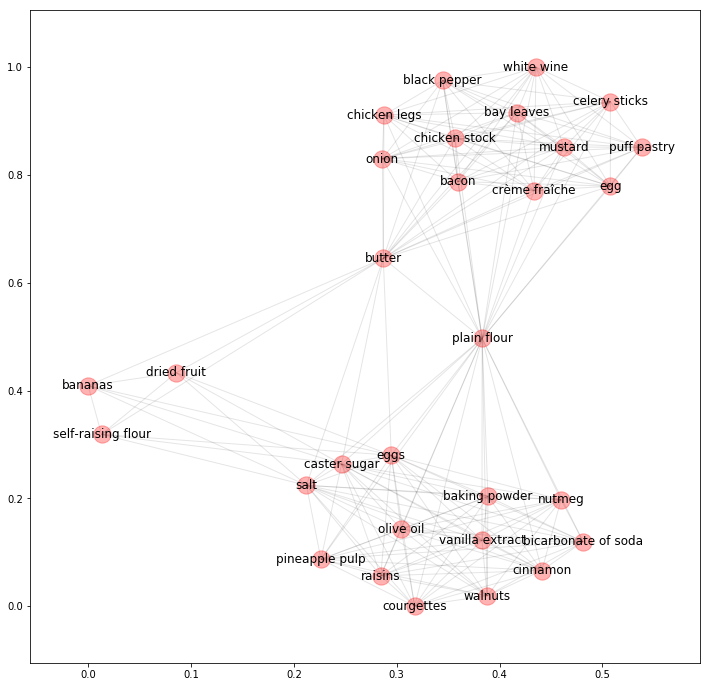

In [296]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.spring_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")


### Random layout

hi


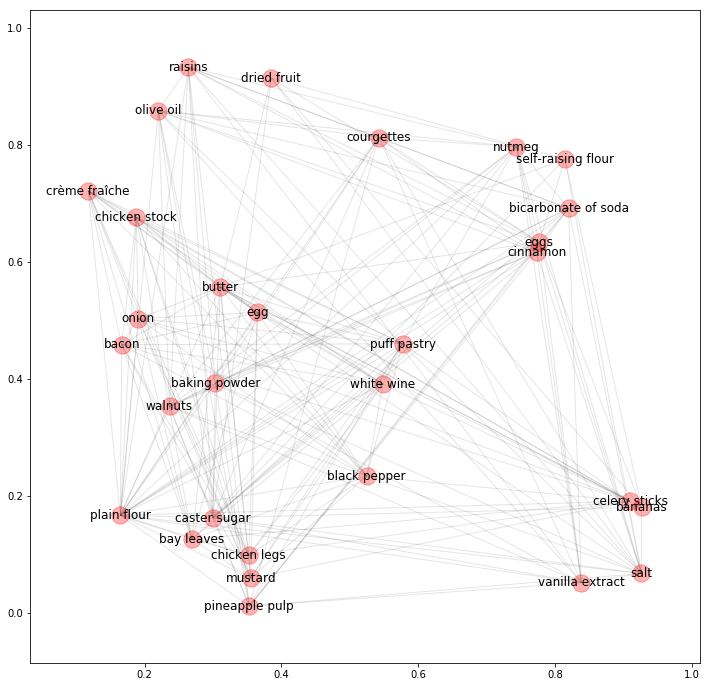

In [297]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.random_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

### Circular layout

hi


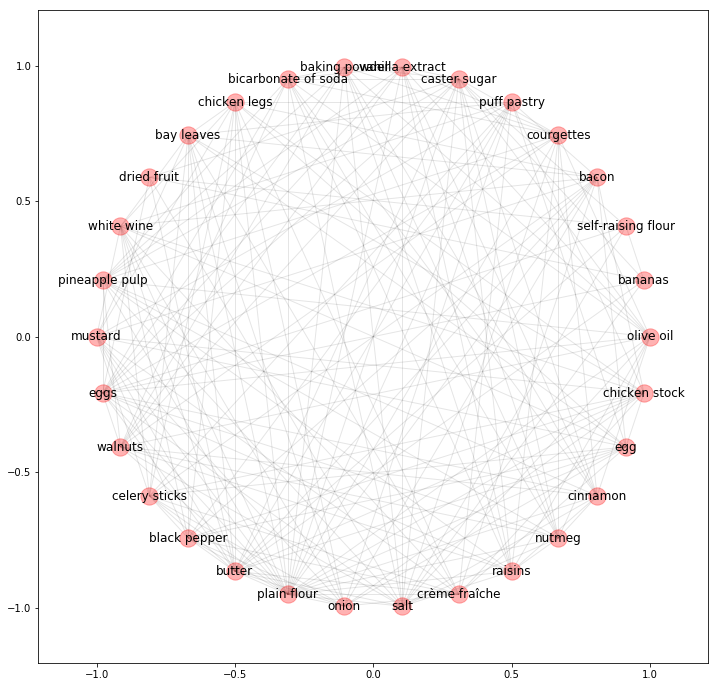

In [298]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.circular_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

### Spectral layout

hi


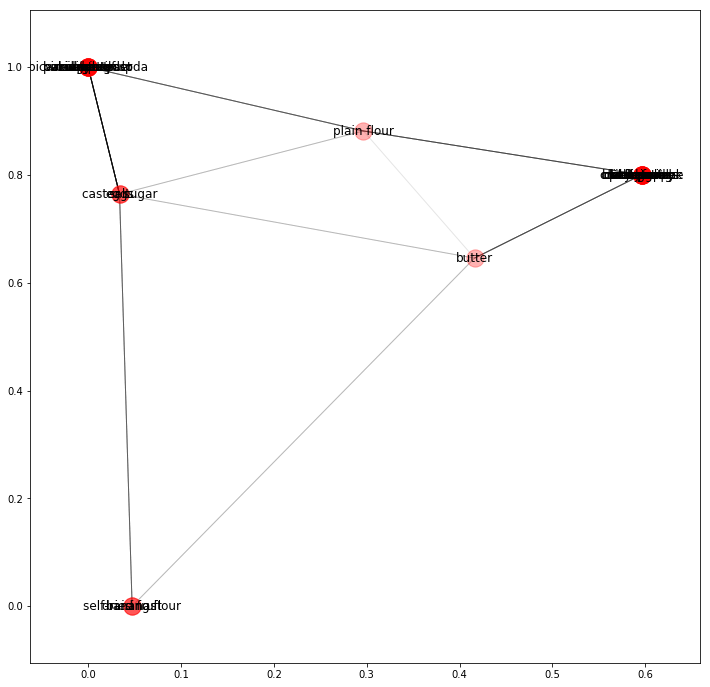

In [299]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.spectral_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

### Force-directed graph layout

hi


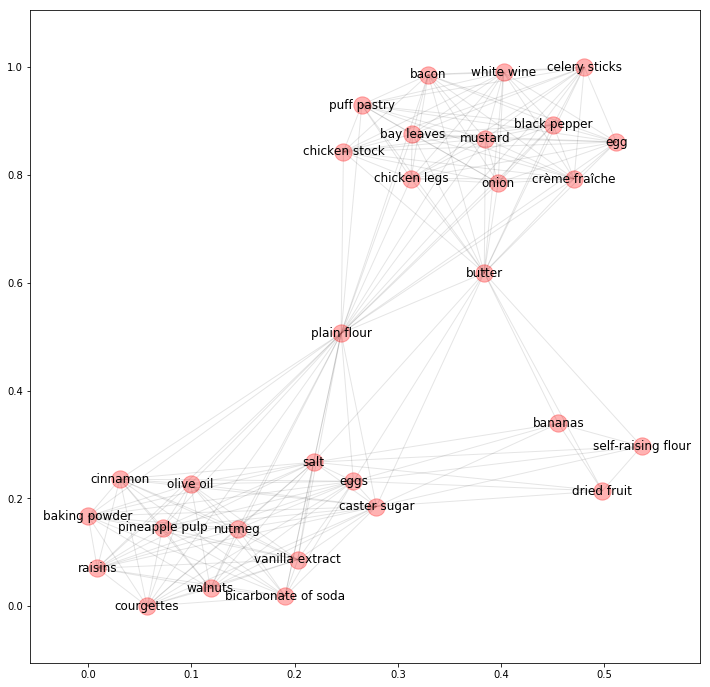

In [310]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.spring_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

### Graphviz Layout

hi


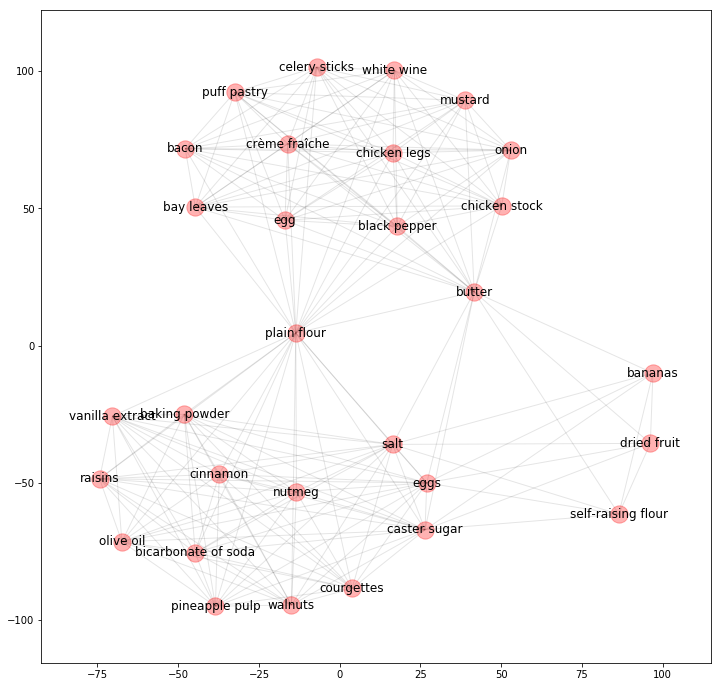

In [300]:
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=graphviz_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

## Mapping attributes to nodes

In [302]:
node_neighbors = [len(ingredients_map[n]["coingredients"]) for n in G.nodes()]
max_neighbors = max(node_neighbors)
max_width = 400
node_widths = [(max_width * n) / max_neighbors for n in node_neighbors]

### Number of connections mapped onto the node size

hi


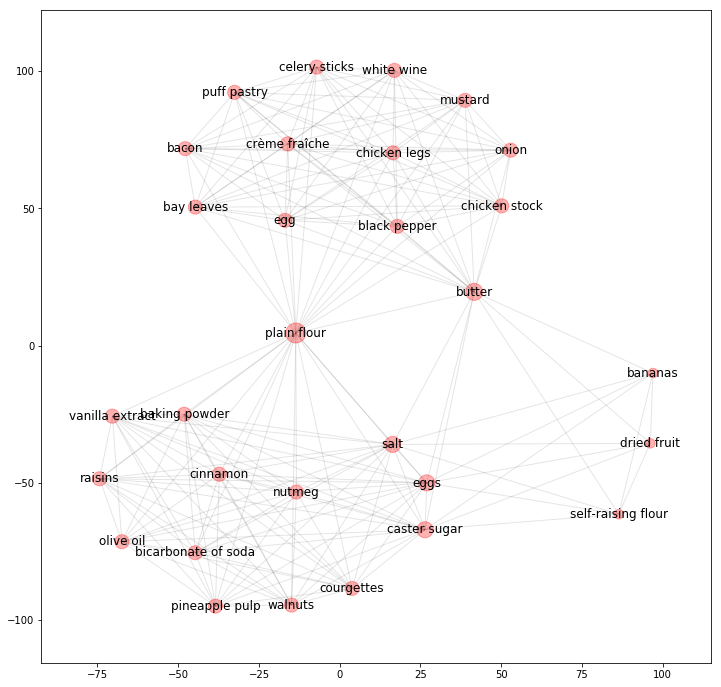

In [312]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=graphviz_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3,node_size = node_widths)
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

In [313]:
food_types = {'onion': 'vegetable',
             'black pepper': 'spice',
              'bay leaves': 'spice',
              'bacon': 'meat',
              'chicken stock': 'liquid',
              'crème fraîche': 'dairy',
              u'cr\xe8me fra\xeeche': 'dairy',
              'celery sticks': 'vegetable',
              'onion' : 'vegetable',
              'chicken legs': 'meat',
              'puff pastry' : 'wheat',
              'white wine' : 'liquid',
              'mustard' : 'condiment',
              'egg' : 'dairy',
              'plain flour' : 'wheat',
              'dried fruit' : 'fruit',
              'bananas ' : 'fruit',
              'bananas' : 'fruit',
              'self-raising flour' : 'wheat',
              'caster sugar' : 'spice',
              'eggs' : 'dairy',
              'salt' : 'spice',
              'walnuts' : 'nut',
              'pineapple pulp' : 'fruit',
              'nutmeg' : 'spice',
              'baking powder' : 'spice',
              'courgettes' : 'vegetable',
              'olive oil' : 'condiment',
              'bicarbonate of soda' : 'spice',
              'raisins' : 'fruit',
              'cinnamon' : 'spice',
              'vanilla extract': 'spice',
              'butter': 'dairy'
             }

food_types_to_colors = {'vegetable': 'green', 
                        'liquid' : 'blue',
                        'condiment' : 'orange',
                        'dairy' : 'yellow',
                        'nut': 'brown',
                        'fruit': 'red',
                        'spice': 'black',
                        'wheat': 'beige',
                        'meat': 'red'}

node_colors = [food_types_to_colors[food_types[n]] for n in G.nodes()]

hi


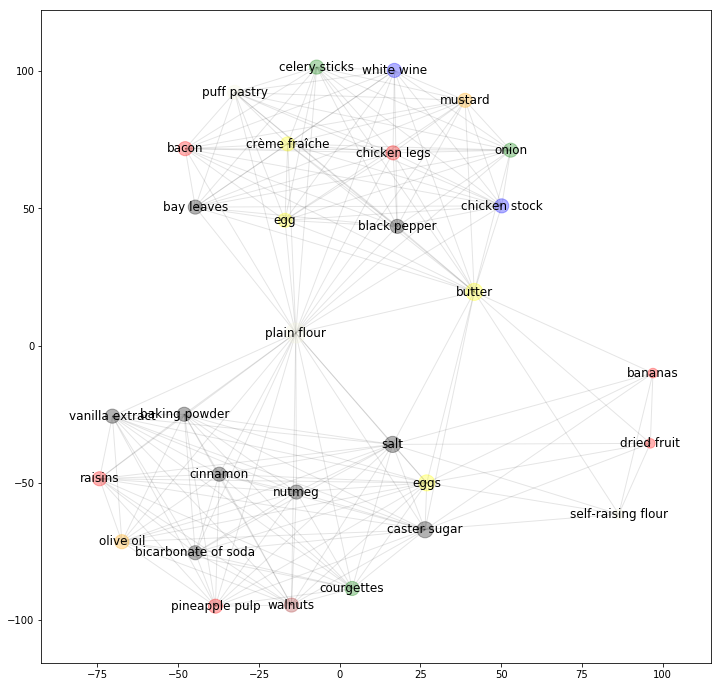

In [314]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=graphviz_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3,
                       node_size = node_widths,
                       node_color = node_colors
                      )
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
print("hi")

## More recipes

hi


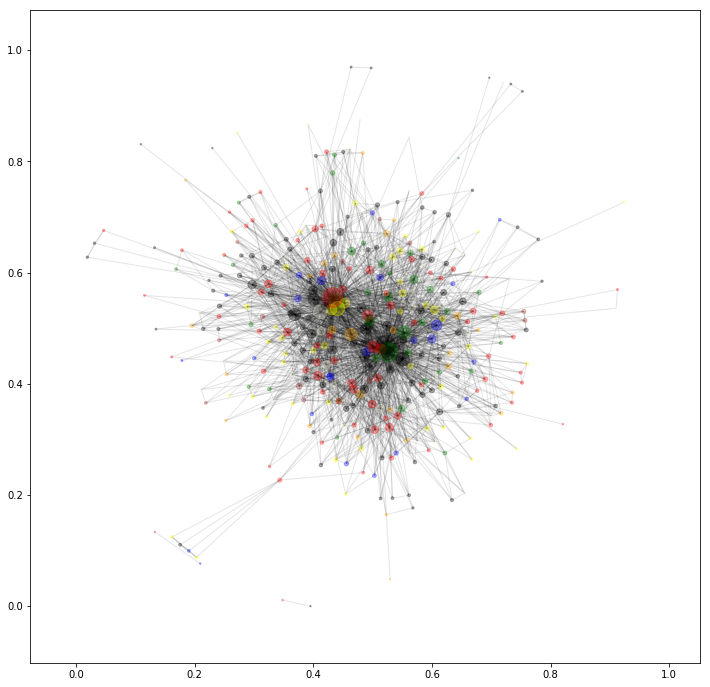

In [333]:
ingredients_map = create_ingredients_map(responses.items()[:100], clean_ingredient)
#print("\n".join(ingredients_map.keys()[:]))


import networkx as nx

G = nx.Graph()
G.add_nodes_from(ingredients_map.keys())

for ingredient_name,ingredient_data in ingredients_map.items():
    for coingredient in ingredient_data['coingredients']:
        G.add_edge(ingredient_name, coingredient)
        
node_neighbors = [len(ingredients_map[n]["coingredients"]) for n in G.nodes()]
max_neighbors = max(node_neighbors)
max_width = 400
node_widths = [(max_width * n) / max_neighbors for n in node_neighbors]

import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.spring_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3,
                       node_size = node_widths,
                       node_color = node_colors
                      )
nx.draw_networkx_edges(G, pos, alpha=0.1)
#nx.draw_networkx_labels(G, pos)
print('hi')

In [334]:
len(ingredients_map.keys())

378

In [335]:
ingredients_map.keys()

[u'duck breasts',
 u'self-raising flour',
 u'ale',
 u'Worcestershire sauce',
 u'courgettes',
 u'salmon fillet',
 u'parmesan',
 u'mascarpone',
 u'milk',
 u'cayenne pepper',
 u'pancetta',
 u'garlic clove',
 u'white bread',
 u'celery leaves',
 u'caraway seeds',
 u'vanilla extract',
 u'yeast',
 u'ginger ale',
 u'figs',
 u'white wine or sherry',
 u'strawberry jam',
 u'curry paste',
 u'broad beans',
 u'limes',
 u'asparagus',
 u'prosciutto',
 u'courgette',
 u'tomato and onion salad',
 u'chilli powder',
 u'Irish stout',
 u'penne pasta',
 u'bacon',
 u'Bramley apples',
 u'steaks',
 u'caster sugar',
 u'spaghetti',
 u'port',
 u'walnut oil',
 u'tarragon',
 u'vegetable oil until crisp',
 u'bay leaves',
 u'dried chilli flakes',
 u'chickpeas',
 u'scallops',
 u'cocoa powder',
 u'mussels',
 u'celery sticks',
 u'mozzarella',
 u'vinegar',
 u'Dijon mustard',
 u'cinnamon',
 u'sea salt',
 u'vegetable oil',
 u'apple',
 u'liqueur',
 u'King Edward potatoes',
 u'sugar',
 u'egg',
 u'lime',
 u'orange peppers',
 u'